## Imports

In [741]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import yfinance as yf
import cplex

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cvxpy as cp

from datetime import datetime, timedelta
from math import sqrt

import os

%matplotlib inline

In [742]:
model = "gpt-4o-2024-11-20" 
# model = "gpt-4.1"
# model = "o4-mini"
# model = "claude-3-7-sonnet-20250219"
# model = "claude-sonnet-4-20250514"
# model = "claude-opus-4-20250514"
# model = "deepseek-chat"
# model = "deepseek-reasoner"
# model = "gemini-2.5-pro-preview-05-06"
# model = "grok-3-latest"
# model = "grok-3-mini-latest"

avg_weights = True

Install CPLEX solver. To setup CPLEX solver for Python:
* Use the script `setup.py` located in the directory `yourCPLEXhome/python`
* Execute the following command from the command line `python yourCPLEXhome/python/setup.py install` or `python yourCPLEXhome/python/setup.py install --home yourPythonPackageshome`
* Set the environment variable `PYTHONPATH` to `yourCPLEXhome/python/VERSION/PLATFORM`

## Identify sector parameters

To process the sector, uncomment the cell. Comment cells with sectors that are not processed at the moment.

In [743]:
# sector_name = 'energy'
# sector_name_full = 'Energy'
# sector_ticker = '^GSPE'
# full_ticker = 'SP500-10'

In [744]:
# sector_name = 'materials'
# sector_name_full = 'Materials'
# sector_ticker = '^SP500-15'
# full_ticker = 'SP500-15'

In [745]:
# sector_name = 'industrials'
# sector_name_full = 'Industrials'
# sector_ticker = '^SP500-20'
# full_ticker = 'SP500-20'

In [746]:
# sector_name = 'consumer_discretionary'
# sector_name_full = 'Consumer Discretionary'
# sector_ticker = '^SP500-25'
# full_ticker = 'SP500-25'

In [747]:
# sector_name = 'consumer_staples'
# sector_name_full = 'Consumer Staples'
# sector_ticker = '^SP500-30'
# full_ticker = 'SP500-30'

In [748]:
# sector_name = 'health_care'
# sector_name_full = 'Health Care'
# sector_ticker = '^SP500-35'
# full_ticker = 'SP500-35'

In [749]:
# sector_name = 'financials'
# sector_name_full = 'Financials'
# sector_ticker = '^SP500-40'
# full_ticker = 'SP500-40'

In [750]:
# sector_name = 'information_technology'
# sector_name_full = 'Information Technology'
# sector_ticker = '^SP500-45'
# full_ticker = 'SP500-45'

In [751]:
# sector_name = 'communication_services'
# sector_name_full = 'Communication Services'
# sector_ticker = '^SP500-50'
# full_ticker = 'SP500-50'

In [752]:
# sector_name = 'utilities'
# sector_name_full = 'Utilities'
# sector_ticker = '^SP500-55'
# full_ticker = 'SP500-55'

In [753]:
sector_name = 'real_estate'
sector_name_full = 'Real Estate'
sector_ticker = '^SP500-60'
full_ticker = 'SP500-60'

## Process data

In [754]:
## In-sample end date (using 5 years of weekly data prior to end date)
insample_enddate = datetime(2024, 9, 30)

## Out-of-sample period (1 Oct 2024 to 31 Dec 2024) (using daily data))
outsample_startdate = datetime(2024, 10, 1)
outsample_enddate   = datetime(2024, 12, 31)

insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to Oct 2024

In [755]:
sp500_df = pd.read_csv('SP500.csv')  
companies = sp500_df[sp500_df['GICS Sector'] == sector_name_full]['Symbol']
companies

30      AMT
41      ARE
43      AVB
71      BXP
79     CBRE
80      CCI
110     CPT
115    CSGP
137     DLR
139     DOC
163    EQIX
164     EQR
168     ESS
177     EXR
192     FRT
230     HST
243    INVH
248     IRM
266     KIM
295     MAA
349       O
373     PLD
384     PSA
391     REG
404    SBAC
415     SPG
458     UDR
467    VICI
475     VTR
485    WELL
494      WY
Name: Symbol, dtype: object

## Load Data

In [756]:
# in-sample
sp500_ins = yf.download(sector_ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust = False)  ## add "auto_adjust = False"
sp500_ins['SP_Return'] = sp500_ins['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_ins.dropna(subset=[('SP_Return', '')], inplace=True) # removed first row with NaN in return
## change subset from ['SP_Return'] to [('SP_Return', '')] for MultiIndex

# out-of-sample
sp500_outs = yf.download(sector_ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust = False)  ## add auto_adjust = False
sp500_outs['SP_Return'] = sp500_outs['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_outs.dropna(subset=[('SP_Return', '')], inplace=True) # removed first row with NaN in return
## change subset from ['SP_Return'] to [('SP_Return', '')] for MultiIndex

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [757]:
insample_data_filename = f'4_returns_insample/SP500_{sector_name}_returns_till_Oct2024.csv'
outsample_data_filename = f'4_returns_outsample/SP500_{sector_name}_returns_since_Oct2024.csv'

In [758]:
if os.path.isfile(insample_data_filename):
    print("Reading data from file", insample_data_filename)
    df_returns = pd.read_csv(insample_data_filename, index_col=0)
else:
    print("Retrieving data from Yahoo Finance")
    returns = {}

    for ticker in companies:
        ticker_saved = ticker
        if '.' in ticker: ticker = ticker.replace('.', '-')
        
        try:
            df_temp = yf.download(ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust = False)

            df_temp['Return'] = df_temp['Adj Close'].pct_change()

            # removing first row because first return will be Nan
            df_temp = df_temp.iloc[1:]

            df_temp = df_temp[df_temp.index.isin(sp500_ins.index)]

            if df_temp['Return'].isna().any():
                print(f'Skipping {ticker} due to missing returns.')
                continue

            returns[ticker_saved] = df_temp['Return']

        except Exception as e:
            print(f'Failed to download {ticker} due to error: {e}')

    df_returns = pd.DataFrame(returns)
    df_returns.to_csv(insample_data_filename)

Reading data from file 4_returns_insample/SP500_real_estate_returns_till_Oct2024.csv


In [759]:
if os.path.isfile(outsample_data_filename):
    print("Reading data from file", outsample_data_filename)
    df_returnsOUT = pd.read_csv(outsample_data_filename, index_col=0)
else:
    print("Retrieving data from Yahoo Finance")
    returnsOS = {}

    for ticker in companies:
        ticker_saved = ticker
        if '.' in ticker: ticker = ticker.replace('.', '-')
        
        try:
            df_temp = yf.download(ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust = False)

            df_temp['Return'] = df_temp['Adj Close'].pct_change()
            
            # removing first row because first return will be NaN
            df_temp = df_temp.iloc[1:]            

            df_temp = df_temp[df_temp.index.isin(sp500_outs.index)]

            # If not all dates in S&P 500 data are present in stock data, skip this stock
            if not sp500_outs.index.isin(df_temp.index).all():
                print(f'Skipping {ticker} due to mismatch in trading dates.')
                continue

            # If there are still NaN values in stock returns, skip this stock
            if df_temp['Return'].isna().any():
                print(f'Skipping {ticker} due to missing returns.')
                continue

            returnsOS[ticker_saved] = df_temp['Return']

        except Exception as e:
            print(f'Failed to download {ticker} due to error: {e}')

    df_returnsOUT = pd.DataFrame(returnsOS)
    df_returnsOUT.to_csv(outsample_data_filename)

Reading data from file 4_returns_outsample/SP500_real_estate_returns_since_Oct2024.csv


---

In [760]:
index_tickers = ["^GSPC", "^IXIC", sector_ticker]

index_data_outs = pd.DataFrame()

# Download historical data for each index for out-of-sample period
yf_outsample_enddate = outsample_enddate + timedelta(days=1)
for ticker in index_tickers:
    index_df = yf.download(ticker, start=outsample_startdate, end=yf_outsample_enddate, interval='1d', auto_adjust=False)
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_outs[ticker] = index_df['Index_Return']

index_data_outs.index = pd.to_datetime(index_data_outs.index)

valid_index_tickers_outs = []

for ticker in index_tickers:
    # Check if the ticker has continuous data in out-of-sample period
    if ticker in index_data_outs.columns and index_data_outs[ticker].notna().all():
        valid_index_tickers_outs.append(ticker)


index_tickers = valid_index_tickers_outs

print("Valid Index Tickers in Out-of-Sample Period")
print(valid_index_tickers_outs)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Valid Index Tickers in Out-of-Sample Period
['^GSPC', '^IXIC', '^SP500-60']


In [761]:
index_tickers = ["^GSPC", "^IXIC", sector_ticker]

index_data_ins = pd.DataFrame()

# Download historical data for each index for in-sample period
for ticker in index_tickers:
    index_df = yf.download(ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust=False)
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_ins[ticker] = index_df['Index_Return']

index_data_ins.index = pd.to_datetime(index_data_ins.index)

valid_index_tickers_ins = []

for ticker in index_tickers:
    # Check if the ticker has continuous data in in-sample period
    if ticker in index_data_ins.columns and index_data_ins[ticker].notna().all():
        valid_index_tickers_ins.append(ticker)


# index_tickers = valid_index_tickers_ins

print("Valid Index Tickers in In-Sample Period")
print(valid_index_tickers_ins)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Valid Index Tickers in In-Sample Period
['^GSPC', '^IXIC', '^SP500-60']


In [762]:
## In-sample end date (using 5 years of weekly data prior to end date)
insample_enddate = datetime(2024, 9, 30)

## Out-of-sample period (1 Oct 2024 to 31 Dec 2024) (using daily data))
outsample_startdate = datetime(2024, 10, 1)
outsample_enddate   = datetime(2024, 12, 31)

insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to Oct 2024

In [763]:
# in-sample
sp500_ins = yf.download(sector_ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust=False) 
sp500_ins['SP_Return'] = sp500_ins['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_ins.dropna(subset=[('SP_Return','')], inplace=True) # 1256 X 7 (removed first row with NaN in return)

# out-of-sample
sp500_outs = yf.download(sector_ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust=False) 
sp500_outs['SP_Return'] = sp500_outs['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_outs.dropna(subset=[('SP_Return','')], inplace=True) # removed first row with NaN in return 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [764]:
insample_data_filename = f'4_returns_insample/SP500_{sector_name}_returns_till_Oct2024.csv'
outsample_data_filename = f'4_returns_outsample/SP500_{sector_name}_returns_since_Oct2024.csv'

In [765]:
print("Reading data from file", insample_data_filename)
df_returns = pd.read_csv(insample_data_filename, index_col=0)

print("Reading data from file", outsample_data_filename)
df_returnsOUT = pd.read_csv(outsample_data_filename, index_col=0)

Reading data from file 4_returns_insample/SP500_real_estate_returns_till_Oct2024.csv
Reading data from file 4_returns_outsample/SP500_real_estate_returns_since_Oct2024.csv


## TEST: mean cumulative out-of-sample return for each sector

In [766]:
temp_index_data_outs = index_data_outs.copy()
outsample_data = pd.DataFrame(index=temp_index_data_outs.index)
outsample_data[sector_name_full] = (1 + temp_index_data_outs[ticker]).cumprod()
outsample_data.index = pd.to_datetime(outsample_data.index)
outsample_data
print(f"mean cum. return of outdata: {outsample_data.mean()}")
print(f"volatility: {outsample_data.std()} ")

mean cum. return of outdata: Real Estate    0.968768
dtype: float64
volatility: Real Estate    0.028839
dtype: float64 


In [767]:
sectors = ['energy', 'materials', 'industrials', 'consumer_discretionary',\
           'consumer_staples', 'health_care', 'financials', 'information_technology',\
           'communication_services', 'utilities', 'real_estate']

In [768]:
csv_path = 'cached/sector_performance/sector_performance_summary_Oct2024.csv'

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path, index_col=0)
else:
    df = pd.DataFrame(index=sectors, columns=['mean_cum_return', 'volatility'])

mean_ret = outsample_data[sector_name_full].mean()
volatility = outsample_data[sector_name_full].std()

df.loc[sector_name, 'mean_cum_return'] = mean_ret
df.loc[sector_name, 'volatility'] = volatility

df.to_csv(csv_path)

In [769]:
df

,mean_cum_return,volatility
energy,1.005010,0.039955
materials,0.960818,0.039547
industrials,1.015673,0.024299
consumer_discretionary,1.083473,0.080994
consumer_staples,0.989177,0.014190
health_care,0.952833,0.033340
financials,1.072427,0.038721
information_technology,1.064982,0.026138
communication_services,1.045193,0.043657
utilities,0.972051,0.026066


## Processing

In [770]:
def process_sector_data(df_sector):
    stocks = list(df_sector['Stock'].str.replace(" ", "").values)
    eq_weights = [1/len(stocks)] * len(stocks)
    llm_weights = list(df_sector['Weight'].values.astype(float))

    return stocks, eq_weights, llm_weights

In [771]:
# not avg_weights
#gpt
if model == 'gpt-4o-2024-11-20' and not avg_weights:
    csv_filename = f'cached/gpt/4o_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'gpt-4.1' and not avg_weights:
    csv_filename = f'cached/gpt/4.1_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'o4-mini' and not avg_weights:
    csv_filename = f'cached/gpt/o4-mini_weights_assigned/responses20_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat' and not avg_weights:
    csv_filename = f'cached/ds/dsV3_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'deepseek-reasoner' and not avg_weights:
    csv_filename = f'cached/ds/dsR1_weights_assigned/responses20_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219' and not avg_weights:
    csv_filename = f'cached/claude/sonnet-3.7_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514' and not avg_weights:
    csv_filename = f'cached/claude/sonnet-4_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514' and not avg_weights:
    csv_filename = f'cached/claude/opus-4_weights_assigned/responses20_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and not avg_weights:
    csv_filename = f'cached/gemini/gemini_weights_assigned/responses20_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest' and not avg_weights:
    csv_filename = f'cached/grok/grok3_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest' and not avg_weights:
    csv_filename = f'cached/grok/grok3-mini_weights_assigned/responses20_auto_{sector_name}.csv'

# average weights
# gpt
elif model == 'gpt-4o-2024-11-20' and avg_weights:
    csv_filename = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'gpt-4.1' and avg_weights:
    csv_filename = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'o4-mini' and avg_weights:
    csv_filename = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat' and avg_weights:
    csv_filename = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'deepseek-reasoner' and avg_weights:
    csv_filename = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219' and avg_weights:
    csv_filename = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514' and avg_weights:
    csv_filename = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514' and avg_weights:
    csv_filename = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and avg_weights:
    csv_filename = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest' and avg_weights:
    csv_filename = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest' and avg_weights:
    csv_filename = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'

In [772]:
model_name_mapping = {
    "gpt-4o-2024-11-20": "gpt4o",
    "gpt-4.1": "gpt4.1", 
    "o4-mini": "o4-mini",
    "claude-3-7-sonnet-20250219": "sonnet-3.7",
    "claude-sonnet-4-20250514": "sonnet-4",
    "claude-opus-4-20250514": "opus-4",
    "deepseek-chat": "dsV3",
    "deepseek-reasoner": "dsR1",
    "gemini-2.5-pro-preview-05-06": "gemini",
    "grok-3-latest": "grok3",
    "grok-3-mini-latest": "grok3-mini"
}

In [773]:
model_short = model_name_mapping[model]

In [774]:
df_sector = pd.read_csv(csv_filename)

stocks, eq_weights, llm_weights = process_sector_data(df_sector)

# Assign variables dynamically
globals()[f'{model_short}_df_{sector_name}'] = df_sector
globals()[f'{model_short}_stocks_{sector_name}'] = stocks
globals()[f'{model_short}_eq_weights_{sector_name}'] = eq_weights
globals()[f'{model_short}_weights_llm_{sector_name}'] = llm_weights

In [775]:
globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [776]:
globals()[f'{model_short}_stock_returns_{sector_name}']

,PLD,AMT,CCI,EQIX,DLR,SPG,O,AVB,EQR,MAA,VICI,WELL,ARE,EXR,PSA,INVH,HST,CPT,ESS,IRM
Date,,,,,,,,,,,,,,,,,,,,
2024-10-02,-0.003451,-0.000819,-0.027957,0.004077,-0.004180,-0.005957,-0.009206,0.004096,-0.000271,-0.005386,0.000000,-0.004311,-0.007429,-0.005890,-0.013220,-0.008936,0.001140,-0.002284,0.001127,0.009811
2024-10-03,-0.017233,-0.011213,-0.012869,-0.011708,-0.014411,-0.001127,-0.000320,-0.010758,-0.007040,-0.011532,-0.006103,-0.004487,-0.007398,-0.005191,-0.006473,-0.006690,-0.010814,-0.012590,-0.011295,-0.008124
2024-10-04,0.003114,-0.024512,-0.024587,0.000753,-0.001907,0.007306,-0.006250,0.001450,0.002591,-0.003416,-0.004606,-0.007117,-0.004160,-0.038739,-0.021530,0.011420,0.027618,0.000662,0.000518,-0.001267
2024-10-07,-0.019768,-0.001297,-0.002512,-0.007835,-0.003376,-0.012266,-0.005483,-0.013664,-0.008704,-0.006985,0.000000,-0.010274,-0.011662,-0.000472,0.003793,-0.015634,-0.021277,-0.010012,-0.006796,-0.012766
2024-10-08,-0.005500,0.004074,0.008094,0.002874,0.011568,-0.001612,-0.002594,0.002294,-0.000275,-0.003256,-0.003085,0.004024,0.002113,0.009209,0.003548,-0.023824,-0.001144,0.002842,0.001980,0.017727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.007936,0.003538,0.000993,0.013341,-0.000560,-0.001340,0.003978,-0.002251,0.001261,-0.000456,0.006600,0.007863,-0.002622,0.006258,0.004437,0.002800,-0.007143,0.002959,0.002009,0.001142
2024-12-24,0.005377,0.001790,0.002755,0.011090,0.010814,0.011495,0.004528,0.007263,0.010918,0.009326,0.008972,0.007722,0.005358,0.011087,0.006626,0.012100,0.008301,0.010239,0.008652,0.003421
2024-12-26,0.020917,-0.003952,0.001539,-0.001705,-0.004989,0.002596,-0.003193,0.000134,0.002077,0.002972,-0.003762,-0.001580,0.002011,0.000267,0.001729,-0.001237,0.003293,-0.000258,0.003208,0.001421


In [777]:
tickers_sp500out = np.array(df_returnsOUT.columns)

## Efficient frontiers

In [778]:
def frontiers(returns_df, asset_list, num_portf, lb, ub, risk_free_rate, model_name):
    # Calculate the covariance matrix and expected returns and scaling them to ANNUAL
    # ts_freq = np.diff(returns_df.index).min()
    try:
        ts_freq = pd.infer_freq(returns_df.index)[0]

        scalef = 252
        if ts_freq=='W':
            scalef = 52
        elif ts_freq=='M':
            scalef = 12
    except TypeError:        
        scalef = 52
        
    Q = returns_df[asset_list].cov() * scalef  # 52 weeks in a year
    mu_pd = returns_df[asset_list].mean() * scalef
    mu = mu_pd.values
    
    ## Minimum variance portfolio
    w = cp.Variable(len(asset_list))
    prob1 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                      [sum(w) == 1,
                       w >= 0])
    prob1.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_minVar = w.value
    # var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
    ret_minVar = np.dot(mu, w_minVar)
    
    ## Max return portfolio
    w = cp.Variable(len(asset_list))
    prob2 = cp.Problem(cp.Maximize(mu.T@w),
                    [sum(w) == 1,
                     w >= 0])
    prob2.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_maxRet = w.value
    # var_maxRet = np.dot(w_maxRet, np.dot(Q, w_maxRet))
    ret_maxRet = np.dot(mu, w_maxRet)
    
    ## Efficient Frontier
    targetRet = np.linspace(ret_minVar, ret_maxRet, num_portf)
    w = cp.Variable(len(asset_list))
    eps = cp.Parameter()
    eps.value = targetRet[0]
    prob3 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                    [mu.T@w >= eps,
                     sum(w) == 1,
                     w >= 0])
    # Compute efficient frontier
    w_front = []
    var_front = []
    ret_front = []
    sharpe_ratio_front = []
    
    for epsilon in targetRet:
        eps.value = epsilon
        prob3.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
        w_front.append(w.value)
        var_front.append(np.dot(w.value, np.dot(Q, w.value)))
        ret_front.append(np.dot(mu, w.value))
        sharpe_ratio = (np.dot(mu, w.value) - risk_free_rate) / np.sqrt(np.dot(w.value, np.dot(Q, w.value)))
        sharpe_ratio_front.append(sharpe_ratio)
    
    # Find the portfolio with the maximum Sharpe ratio
    max_sharpe_ratio_index = np.argmax(sharpe_ratio_front)
    # weights_max_sharpe = w_front[max_sharpe_ratio_index]
    ret_max_sharpe = ret_front[max_sharpe_ratio_index]
    var_max_sharpe = var_front[max_sharpe_ratio_index]
        
    ## Minimum variance portfolio with bounds
    w = cp.Variable(len(asset_list))
    prob5 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                    [cp.sum(w) == 1,
                     w >= lb,
                     w <= ub])
    prob5.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_minVar_bounded = w.value
    # var_minVar_bounded = np.dot(w_minVar_bounded, np.dot(Q, w_minVar_bounded))
    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_Oct2024_minvar_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in w_minVar_bounded]))

    ret_minVar_bounded = np.dot(mu, w_minVar_bounded)
    
    ## Max return portfolio with bounds
    w = cp.Variable(len(asset_list))
    prob6 = cp.Problem(cp.Maximize(mu.T@w),
                        [cp.sum(w) == 1,
                         w >= lb,
                         w <= ub])
    prob6.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_maxRet_bounded = w.value
    # var_maxRet_bounded = np.dot(w_maxRet_bounded, np.dot(Q, w_maxRet_bounded))
    ret_maxRet_bounded = np.dot(mu, w_maxRet_bounded)

    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_Oct2024_maxret_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in w_maxRet_bounded]))
    # ret_maxRet_bounded = np.dot(mu, w_maxRet_bounded)    

    ## Efficient Frontier with bounds
    targetRetB = np.linspace(ret_minVar_bounded, ret_maxRet_bounded, num_portf)
    w = cp.Variable(len(asset_list))
    eps = cp.Parameter()
    eps.value = targetRetB[0]
    prob7 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                        [mu.T @ w >= eps,
                         cp.sum(w) == 1,
                         w >= lb,
                         w <= ub])
    w_front_bounded = []
    var_front_bounded = []
    ret_front_bounded = []
    sharpe_ratio_front_bounded = []
    
    for epsilon in targetRetB:
        eps.value = epsilon
        prob7.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
        w_front_bounded.append(w.value)
        var_front_bounded.append(np.dot(w.value, np.dot(Q, w.value)))

        ret_front_bounded.append(np.dot(mu, w.value))
        
        sharpe_ratio = (np.dot(mu, w.value) - risk_free_rate) / np.sqrt(np.dot(w.value, np.dot(Q, w.value)))
        sharpe_ratio_front_bounded.append(sharpe_ratio)
        
    # Find the portfolio with the maximum Sharpe ratio
    max_sharpe_ratio_bounded_index = np.argmax(sharpe_ratio_front_bounded)
    weights_max_sharpe_bounded = w_front_bounded[max_sharpe_ratio_bounded_index]
    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_Oct2024_maxsharpe_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in weights_max_sharpe_bounded]))
    ret_max_sharpe_bounded = ret_front_bounded[max_sharpe_ratio_bounded_index]
    var_max_sharpe_bounded = var_front_bounded[max_sharpe_ratio_bounded_index]

    return (ret_front, var_front, ret_max_sharpe, var_max_sharpe, \
            ret_front_bounded, var_front_bounded, ret_max_sharpe_bounded, \
                var_max_sharpe_bounded, w_minVar_bounded, w_maxRet_bounded, weights_max_sharpe_bounded)

In [779]:
lbA = 0.03
ubA = 0.13

In [780]:
df_returns = pd.read_csv(f'4_returns_insample/SP500_{sector_name}_returns_till_Oct2024.csv')
try:
    df_returns['Date'] = pd.to_datetime(df_returns['Date'], format='%Y-%m-%d %H:%M:%S')
except ValueError:
    df_returns['Date'] = pd.to_datetime(df_returns['Date'] + ' 00:00:00', format='%Y-%m-%d %H:%M:%S')

df_returns = df_returns.set_index('Date')

In [781]:
# ret_front20, var_front20, ret_max_sharpe20, var_max_sharpe20, ret_front_bounded20, \
#     var_front_bounded20, ret_max_sharpe_bounded20, var_max_sharpe_bounded20, w_min_var_bounded20, \
#     w_max_ret_bounded20, w_max_sharpe_bounded20 = frontiers(df_returns, globals()[f'stocks_{sector_name}'], 200, lbA, ubA, 0.01, model)

In [782]:
ret_front20, var_front20, ret_max_sharpe20, var_max_sharpe20, ret_front_bounded20, \
    var_front_bounded20, ret_max_sharpe_bounded20, var_max_sharpe_bounded20, w_min_var_bounded20, \
    w_max_ret_bounded20, w_max_sharpe_bounded20 = frontiers(df_returns, globals()[f'{model_short}_stocks_{sector_name}'], 200, lbA, ubA, 0.01, model_short)

globals()[f'{model_short}_ret_front20_{sector_name}'] = ret_front20
globals()[f'{model_short}_var_front20_{sector_name}'] = var_front20
globals()[f'{model_short}_ret_max_sharpe20_{sector_name}'] = ret_max_sharpe20
globals()[f'{model_short}_var_max_sharpe20_{sector_name}'] = var_max_sharpe20
globals()[f'{model_short}_ret_front_bounded20_{sector_name}'] = ret_front_bounded20
globals()[f'{model_short}_var_front_bounded20_{sector_name}'] = var_front_bounded20
globals()[f'{model_short}_ret_max_sharpe_bounded20_{sector_name}'] = ret_max_sharpe_bounded20
globals()[f'{model_short}_var_max_sharpe_bounded20_{sector_name}'] = var_max_sharpe_bounded20
globals()[f'{model_short}_w_min_var_bounded20_{sector_name}'] = w_min_var_bounded20
globals()[f'{model_short}_w_max_ret_bounded20_{sector_name}'] = w_max_ret_bounded20
globals()[f'{model_short}_w_max_sharpe_bounded20_{sector_name}'] = w_max_sharpe_bounded20

## Plot frontiers

In [783]:
def plot_frontiers(returns_df, params_llm, sector, model):
    asset_list, weights_eq, weights_llm, ret_front, var_front, ret_max_sharpe, \
        var_max_sharpe, ret_front_bounded, var_front_bounded, ret_max_sharpe_bounded, \
            var_max_sharpe_bounded = params_llm
    
    # Calculate the covariance matrix and expected returns and scaling them to ANNUAL
    try:
        ts_freq = pd.infer_freq(returns_df.index)[0]
        ##print(ts_freq) ##

        scalef = 252
        if ts_freq=='W':
            scalef = 52
        elif ts_freq=='M':
            scalef = 12
    except TypeError:        
        scalef = 252 ##
    ##print (scalef)##

    Q = returns_df[asset_list].cov() * scalef  # 52 weeks in a year
    mu_pd = returns_df[asset_list].mean() * scalef
    mu = mu_pd.values
     
    # Compute expected returns, variances, and standard deviations for LLM weighted portfolio
    ret_llm = np.dot(mu, weights_llm)
    var_llm = np.dot(weights_llm, np.dot(Q, weights_llm))
    std_llm = np.sqrt(var_llm)

    # Compute expected returns, variances, and standard deviations for equally weighted portfolio
    ret_eq = np.dot(mu, weights_eq)
    var_eq = np.dot(weights_eq, np.dot(Q, weights_eq))
    std_eq = np.sqrt(var_eq)

    fig = plt.figure(figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
    ax = plt.gca()
    plt.rcParams['figure.figsize'] = [10, 5]

    ax.scatter(x=np.sqrt(var_front[0]), y=ret_front[0], marker='D', s=50, color='DarkGreen', label='minimum variance portfolio')
    ax.scatter(x=np.sqrt(var_front[-1]), y=ret_front[-1], marker='s', s=50, color='DarkMagenta', label='maximum return portfolio')
    ax.scatter(x=np.sqrt(var_front_bounded[0]), y=ret_front_bounded[0], marker='D', s=50, color='pink', label='minimum variance portfolio bounded')
    ax.scatter(x=np.sqrt(var_front_bounded[-1]), y=ret_front_bounded[-1], marker='s', s=50, color='brown', label='maximum return portfolio bounded')

    ax.plot(np.sqrt(var_front), ret_front, 'k--', label='efficient frontier')

    # Plot efficient frontier for bounded case
    ax.plot(np.sqrt(var_front_bounded), ret_front_bounded, 'k-', label='efficient frontier bounded')

    # Plot volatility versus expected return for individual stocks
    ax.scatter(x=np.sqrt(np.diag(Q)), y=mu, color='lightgrey', label='individual stocks')

    ax.scatter(x=std_llm, y=ret_llm, marker='o', s=50, color='red', label='LLM weighted LLM portfolio')

    ax.scatter(x=std_eq, y=ret_eq, marker='o', s=50, color='yellow', label='Equally weighted LLM portfolio')

    ax.scatter(x=np.sqrt(var_max_sharpe), y=ret_max_sharpe, marker='o', s=50, color='green', label='Maximum Sharpe portfolio')

    ax.scatter(x=np.sqrt(var_max_sharpe_bounded), y=ret_max_sharpe_bounded, marker='o', s=50, color='cyan', label='Maximum Sharpe portfolio bounded')

    # Format and display the final plot
    ax.axis([0.9 * np.sqrt(var_front[0]), 1.2 * np.max(np.sqrt(np.diag(Q))), np.min(mu) - 0.1 * (np.max(mu) - np.min(mu)), 1.1 * ret_front[-1]])
    ax.set_xlabel('Volatility (Standard Deviation)')
    ax.set_ylabel('Expected Return (annualized)')
    plt.title(f'Efficient frontier for {str(len(asset_list))} stocks selected by {model} for {sector}')
    ax.legend(loc="lower right", fontsize='small')  # Adjust font size here
    ax.grid()
    plt.show()

In [784]:
# params_llm = [globals()[f'stocks_{sector_name}'], globals()[f'eq_weights_{sector_name}'], globals()[f'weights_llm_{sector_name}'], \
#                ret_front20, var_front20, ret_max_sharpe20, var_max_sharpe20, ret_front_bounded20, var_front_bounded20, ret_max_sharpe_bounded20,\
#                   var_max_sharpe_bounded20]


In [785]:
params_llm = [globals()[f'{model_short}_stocks_{sector_name}'], globals()[f'{model_short}_eq_weights_{sector_name}'], globals()[f'{model_short}_weights_llm_{sector_name}'], \
               globals()[f'{model_short}_ret_front20_{sector_name}'], globals()[f'{model_short}_var_front20_{sector_name}'], globals()[f'{model_short}_ret_max_sharpe20_{sector_name}'], globals()[f'{model_short}_var_max_sharpe20_{sector_name}'], \
               globals()[f'{model_short}_ret_front_bounded20_{sector_name}'], globals()[f'{model_short}_var_front_bounded20_{sector_name}'], globals()[f'{model_short}_ret_max_sharpe_bounded20_{sector_name}'], \
               globals()[f'{model_short}_var_max_sharpe_bounded20_{sector_name}']]


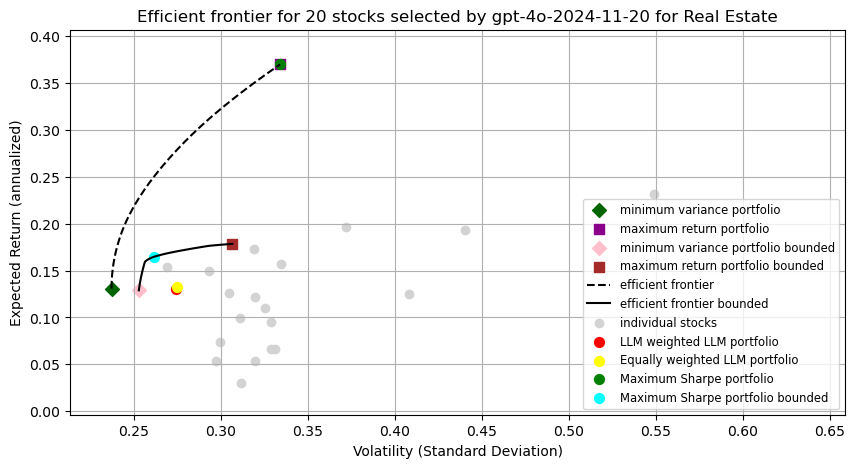

In [786]:
## I think this is for in-sample data?
plot_frontiers(df_returns, params_llm, sector_name_full, model)

## Plot portfolio performance

In [787]:
# Weights of all portfolios
weights = {
    f"LLM_weighted_{sector_name}": globals()[f'{model_short}_weights_llm_{sector_name}'],
    f"LLM_equal_{sector_name}": globals()[f'{model_short}_eq_weights_{sector_name}'],
    "LLM Min Var": globals()[f'{model_short}_w_min_var_bounded20_{sector_name}'],
    "LLM Max Ret": globals()[f'{model_short}_w_max_ret_bounded20_{sector_name}'],
    "LLM Max Sharpe": globals()[f'{model_short}_w_max_sharpe_bounded20_{sector_name}']
}

In [788]:
temp_stock_return = globals()[f'{model_short}_stock_returns_{sector_name}']
temp_stock_return.index = pd.to_datetime(temp_stock_return.index)
first_date = temp_stock_return.index[0]
previous_trading_date = first_date - BDay(1)
full_index = [previous_trading_date] + list(temp_stock_return.index)
cumulative_returns_llm = pd.DataFrame(index=full_index)  ## 创建df 只有index-日期 这一列

In [789]:
i = 0
for name, weight in weights.items():
    temp_stock_return = globals()[f'{model_short}_stock_returns_{sector_name}']
    first_date = temp_stock_return.index[0]
    temp_stock_return.index = pd.to_datetime(temp_stock_return.index)
    previous_trading_date = first_date - BDay(1)
    baseline_row = pd.DataFrame(
        data=np.zeros((1, temp_stock_return.shape[1])),  
        index=[previous_trading_date],                    
        columns=temp_stock_return.columns               
    )
    temp_stock_return_with_baseline = pd.concat([baseline_row, temp_stock_return])
    portfolio_return = (temp_stock_return_with_baseline * weight).sum(axis=1)
    cumulative_returns_llm[name] = (1 + portfolio_return).cumprod()
    i+=1

In [790]:
cumulative_returns_llm

,LLM_weighted_real_estate,LLM_equal_real_estate,LLM Min Var,LLM Max Ret,LLM Max Sharpe
2024-10-01,1.000000,1.000000,1.000000,1.000000,1.000000
2024-10-02,0.995495,0.996048,0.994000,0.997583,0.997304
2024-10-03,0.985999,0.987214,0.984227,0.990295,0.988825
2024-10-04,0.980669,0.983134,0.978016,0.987277,0.981493
2024-10-07,0.972677,0.974925,0.971830,0.978845,0.974896
...,...,...,...,...,...
2024-12-23,0.922486,0.928501,0.938541,0.937905,0.922336
2024-12-24,0.929340,0.935828,0.946011,0.945311,0.929610
2024-12-26,0.931027,0.936834,0.946325,0.945795,0.930243
2024-12-27,0.922611,0.927906,0.937848,0.936852,0.921651


In [791]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_llm[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_llm.index = pd.to_datetime(cumulative_returns_llm.index)
outsample_data = cumulative_returns_llm.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()


for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))
    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))


num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of {num_asset} Asset Portfolios ({model}, equal weight) and {full_ticker} ({sector_name_full}) from Oct 24 to Dec 24',
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified"
)

fig.show()

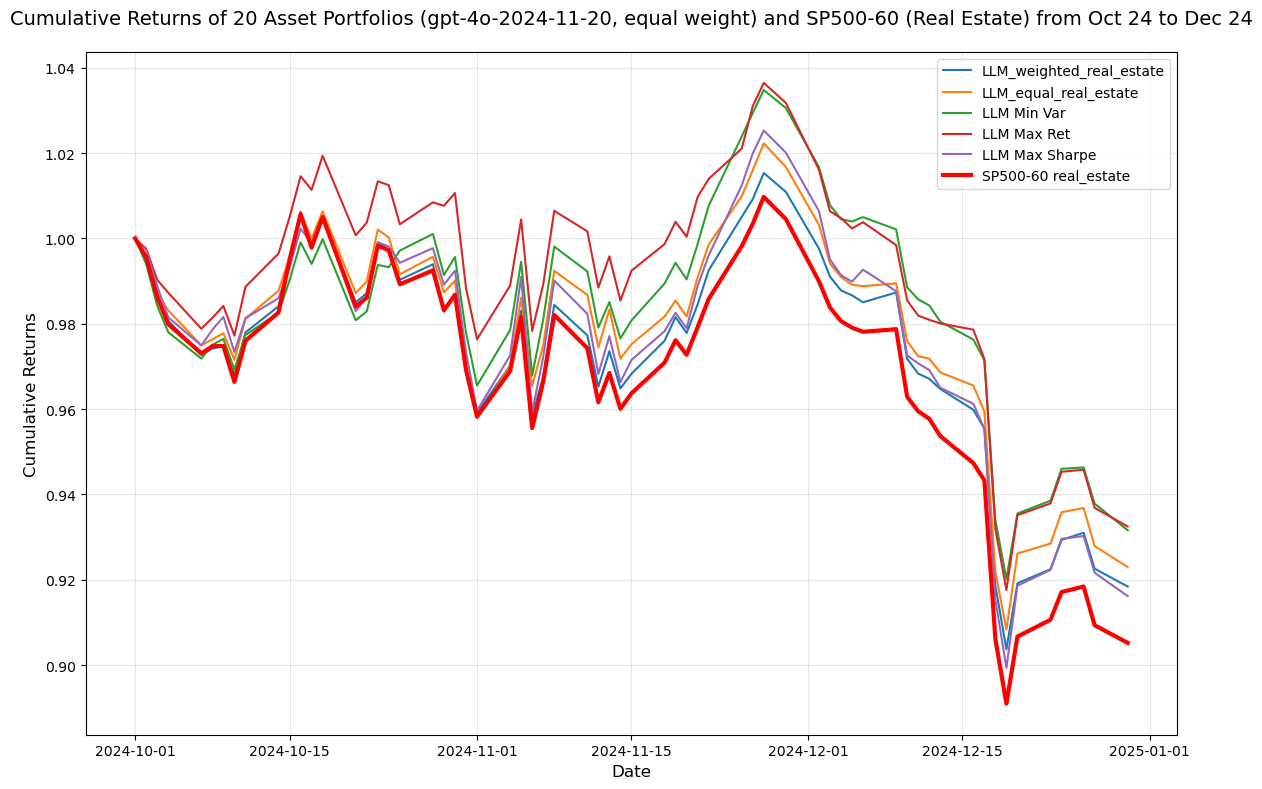

In [792]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_llm[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_llm.index = pd.to_datetime(cumulative_returns_llm.index)
outsample_data = cumulative_returns_llm.loc[outsample_startdate:outsample_enddate]

fig, ax = plt.subplots(figsize=(12, 8))

for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        ax.plot(outsample_data.index, 
                outsample_data[column], 
                linewidth=3, 
                color='red', 
                label=column)
    else:
        ax.plot(outsample_data.index, 
                outsample_data[column], 
                label=column)

num_asset = len(df_sector)
ax.set_title(f'Cumulative Returns of {num_asset} Asset Portfolios ({model}, equal weight) and {full_ticker} ({sector_name_full}) from Oct 24 to Dec 24', 
             fontsize=14, pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Returns', fontsize=12)


ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
# fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Comparing LLM Models: OpenAI, Anthropic, DeepSeek, Google, and X.AI

In [793]:
for model, model_short in model_name_mapping.items():
    if model == 'gpt-4o-2024-11-20' and avg_weights:
        csv_filename = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'gpt-4.1' and avg_weights:
        csv_filename = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'o4-mini' and avg_weights:
        csv_filename = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    # ds
    elif model == 'deepseek-chat' and avg_weights:
        csv_filename = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'deepseek-reasoner' and avg_weights:
        csv_filename = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    # claude
    elif model == 'claude-3-7-sonnet-20250219' and avg_weights:
        csv_filename = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'claude-sonnet-4-20250514' and avg_weights:
        csv_filename = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'claude-opus-4-20250514' and avg_weights:
        csv_filename = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    # gemini
    elif model == 'gemini-2.5-pro-preview-05-06' and avg_weights:
        csv_filename = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    # grok
    elif model == 'grok-3-latest' and avg_weights:
        csv_filename = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'grok-3-mini-latest' and avg_weights:
        csv_filename = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    
    df_sector = pd.read_csv(csv_filename)

    stocks, eq_weights, llm_weights = process_sector_data(df_sector)

    # Assign variables dynamically
    globals()[f'{model_short}_df_{sector_name}'] = df_sector
    globals()[f'{model_short}_stocks_{sector_name}'] = stocks
    globals()[f'{model_short}_eq_weights_{sector_name}'] = eq_weights
    globals()[f'{model_short}_weights_llm_{sector_name}'] = llm_weights

In [794]:
for model, model_short in model_name_mapping.items():
    globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [795]:
for model, model_short in model_name_mapping.items():
    ret_front20, var_front20, ret_max_sharpe20, var_max_sharpe20, ret_front_bounded20, \
        var_front_bounded20, ret_max_sharpe_bounded20, var_max_sharpe_bounded20, w_min_var_bounded20, \
        w_max_ret_bounded20, w_max_sharpe_bounded20 = frontiers(df_returns, globals()[f'{model_short}_stocks_{sector_name}'], 200, lbA, ubA, 0.01, model_short)

    globals()[f'{model_short}_ret_front20_{sector_name}'] = ret_front20
    globals()[f'{model_short}_var_front20_{sector_name}'] = var_front20
    globals()[f'{model_short}_ret_max_sharpe20_{sector_name}'] = ret_max_sharpe20
    globals()[f'{model_short}_var_max_sharpe20_{sector_name}'] = var_max_sharpe20
    globals()[f'{model_short}_ret_front_bounded20_{sector_name}'] = ret_front_bounded20
    globals()[f'{model_short}_var_front_bounded20_{sector_name}'] = var_front_bounded20
    globals()[f'{model_short}_ret_max_sharpe_bounded20_{sector_name}'] = ret_max_sharpe_bounded20
    globals()[f'{model_short}_var_max_sharpe_bounded20_{sector_name}'] = var_max_sharpe_bounded20
    globals()[f'{model_short}_w_min_var_bounded20_{sector_name}'] = w_min_var_bounded20
    globals()[f'{model_short}_w_max_ret_bounded20_{sector_name}'] = w_max_ret_bounded20
    globals()[f'{model_short}_w_max_sharpe_bounded20_{sector_name}'] = w_max_sharpe_bounded20

In [796]:
temp_stock_return_compare = globals()[f'{model_short}_stock_returns_{sector_name}']
temp_stock_return_compare.index = pd.to_datetime(temp_stock_return_compare.index)
first_date_compare = temp_stock_return_compare.index[0]
previous_trading_date_compare = first_date_compare - BDay(1)
full_index_compare = [previous_trading_date_compare] + list(temp_stock_return_compare.index)

cumulative_returns_compare = pd.DataFrame(index=full_index_compare)

In [797]:
globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [798]:
for model_name, model_short in model_name_mapping.items():
    dict_name = f"weights_{model_short}"

    weights_dict = {
        f"{model_short}_weighted_{sector_name}": globals()[f'{model_short}_weights_llm_{sector_name}'],
        f"{model_short}_equal_{sector_name}": globals()[f'{model_short}_eq_weights_{sector_name}'],
        f"{model_short} Min Var": globals()[f'{model_short}_w_min_var_bounded20_{sector_name}'],
        f"{model_short} Max Ret": globals()[f'{model_short}_w_max_ret_bounded20_{sector_name}'],
        f"{model_short} Max Sharpe": globals()[f'{model_short}_w_max_sharpe_bounded20_{sector_name}']
    }
    
    globals()[dict_name] = weights_dict

In [799]:
model_shorts = ["gpt4o", "gpt4.1", "o4-mini", "sonnet-3.7", "sonnet-4", "opus-4", 
                "dsV3", "dsR1", "gemini", "grok3", "grok3-mini"]

for model_short in model_shorts:
    weights_dict = globals()[f'weights_{model_short}']
    
    temp_stock_return_compare = globals()[f'{model_short}_stock_returns_{sector_name}']

    for name, weight in weights_dict.items():
        temp_stock_return_compare.index = pd.to_datetime(temp_stock_return_compare.index)
        first_date_compare = temp_stock_return_compare.index[0]
        previous_trading_date_compare = first_date_compare - BDay(1)
        baseline_row1 = pd.DataFrame(
            data=np.zeros((1, temp_stock_return_compare.shape[1])),  
            index=[previous_trading_date_compare],                    
            columns=temp_stock_return_compare.columns               
        )
        temp_stock_return_compare_with_baseline = pd.concat([baseline_row1, temp_stock_return_compare])

        portfolio_return_compare = (temp_stock_return_compare_with_baseline * weight).sum(axis=1)
        cumulative_returns_compare[name] = (1 + portfolio_return_compare).cumprod()

print(cumulative_returns_compare.columns)

Index(['gpt4o_weighted_real_estate', 'gpt4o_equal_real_estate',
       'gpt4o Min Var', 'gpt4o Max Ret', 'gpt4o Max Sharpe',
       'gpt4.1_weighted_real_estate', 'gpt4.1_equal_real_estate',
       'gpt4.1 Min Var', 'gpt4.1 Max Ret', 'gpt4.1 Max Sharpe',
       'o4-mini_weighted_real_estate', 'o4-mini_equal_real_estate',
       'o4-mini Min Var', 'o4-mini Max Ret', 'o4-mini Max Sharpe',
       'sonnet-3.7_weighted_real_estate', 'sonnet-3.7_equal_real_estate',
       'sonnet-3.7 Min Var', 'sonnet-3.7 Max Ret', 'sonnet-3.7 Max Sharpe',
       'sonnet-4_weighted_real_estate', 'sonnet-4_equal_real_estate',
       'sonnet-4 Min Var', 'sonnet-4 Max Ret', 'sonnet-4 Max Sharpe',
       'opus-4_weighted_real_estate', 'opus-4_equal_real_estate',
       'opus-4 Min Var', 'opus-4 Max Ret', 'opus-4 Max Sharpe',
       'dsV3_weighted_real_estate', 'dsV3_equal_real_estate', 'dsV3 Min Var',
       'dsV3 Max Ret', 'dsV3 Max Sharpe', 'dsR1_weighted_real_estate',
       'dsR1_equal_real_estate', 'dsR1 Mi

In [800]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_compare[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)

In [801]:
cumrets_mean = cumulative_returns_compare.mean().tolist()[:-1]
cumrets_mean = [str(x) for x in cumrets_mean]
with open('metrics/cumulative_returns_all.csv', 'a', encoding='utf-8') as f:
    content = ','.join(cumrets_mean)
    print((f'{sector_name},{content}\n'))
    f.write(f'{sector_name},{content}\n')

real_estate,0.974962043661812,0.9789924660263937,0.9844597719420431,0.9909277164752325,0.9774502068449721,0.9749461123789204,0.9841946729156403,0.9850239225344103,1.0086495358369982,0.9852177824067575,0.9757255774825702,0.9852470699227126,0.9856377317092954,1.0031534272174532,0.979729732897887,0.9728261349811225,0.9808571632179113,0.9830268115039114,0.992689322260805,0.9829723470227574,0.971418351627334,0.9858726328181621,0.9860394659241054,0.9957408902434551,0.9871896103985806,0.9753841892782551,0.9806226260106955,0.9835133088689321,0.9925583996325864,0.9827066657509742,0.9715900088316479,0.9773223318382495,0.9808709391148716,0.9852672601258328,0.9750146727818428,0.9698804159028102,0.9765475615175571,0.9804301135431562,0.9817438506151146,0.9716010035621349,0.9697646958766777,0.9784959915327242,0.9815845445880567,0.9906096303154417,0.9764686039702273,0.9855557691244698,0.9961997111123851,0.9943708764753906,1.0098364785451968,0.9865669469575026,0.9789404791713203,0.9802174993384797,0.98

In [802]:
print(cumulative_returns_compare.columns)

Index(['gpt4o_weighted_real_estate', 'gpt4o_equal_real_estate',
       'gpt4o Min Var', 'gpt4o Max Ret', 'gpt4o Max Sharpe',
       'gpt4.1_weighted_real_estate', 'gpt4.1_equal_real_estate',
       'gpt4.1 Min Var', 'gpt4.1 Max Ret', 'gpt4.1 Max Sharpe',
       'o4-mini_weighted_real_estate', 'o4-mini_equal_real_estate',
       'o4-mini Min Var', 'o4-mini Max Ret', 'o4-mini Max Sharpe',
       'sonnet-3.7_weighted_real_estate', 'sonnet-3.7_equal_real_estate',
       'sonnet-3.7 Min Var', 'sonnet-3.7 Max Ret', 'sonnet-3.7 Max Sharpe',
       'sonnet-4_weighted_real_estate', 'sonnet-4_equal_real_estate',
       'sonnet-4 Min Var', 'sonnet-4 Max Ret', 'sonnet-4 Max Sharpe',
       'opus-4_weighted_real_estate', 'opus-4_equal_real_estate',
       'opus-4 Min Var', 'opus-4 Max Ret', 'opus-4 Max Sharpe',
       'dsV3_weighted_real_estate', 'dsV3_equal_real_estate', 'dsV3 Min Var',
       'dsV3 Max Ret', 'dsV3 Max Sharpe', 'dsR1_weighted_real_estate',
       'dsR1_equal_real_estate', 'dsR1 Mi

## Difference between benchmark (index) and portfolio

In [803]:
cumulative_returns_diff_comp = cumulative_returns_compare.copy()

for model, model_short in model_name_mapping.items():
    cumulative_returns_diff_comp[f'{model_short}_weighted_{sector_name}'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short}_weighted_{sector_name}']
    cumulative_returns_diff_comp[f'{model_short}_equal_{sector_name}'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short}_equal_{sector_name}']
    cumulative_returns_diff_comp[f'{model_short} Min Var'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Min Var']
    cumulative_returns_diff_comp[f'{model_short} Max Ret'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Max Ret']
    cumulative_returns_diff_comp[f'{model_short} Max Sharpe'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Max Sharpe']

In [804]:
cumulative_returns_diff_comp = cumulative_returns_diff_comp.drop(f'{full_ticker} {sector_name}', axis=1)

Negative value means portfolio outperforms the index (because it is the difference between index and portfolio performance, not vice versa).

In [805]:
cumulative_returns_diff_comp.mean()

gpt4o_weighted_real_estate        -0.004804
gpt4o_equal_real_estate           -0.008834
gpt4o Min Var                     -0.014302
gpt4o Max Ret                     -0.020770
gpt4o Max Sharpe                  -0.007292
gpt4.1_weighted_real_estate       -0.004788
gpt4.1_equal_real_estate          -0.014036
gpt4.1 Min Var                    -0.014866
gpt4.1 Max Ret                    -0.038491
gpt4.1 Max Sharpe                 -0.015060
o4-mini_weighted_real_estate      -0.005567
o4-mini_equal_real_estate         -0.015089
o4-mini Min Var                   -0.015480
o4-mini Max Ret                   -0.032995
o4-mini Max Sharpe                -0.009572
sonnet-3.7_weighted_real_estate   -0.002668
sonnet-3.7_equal_real_estate      -0.010699
sonnet-3.7 Min Var                -0.012869
sonnet-3.7 Max Ret                -0.022531
sonnet-3.7 Max Sharpe             -0.012814
sonnet-4_weighted_real_estate     -0.001260
sonnet-4_equal_real_estate        -0.015714
sonnet-4 Min Var                

The table above is used to compose the Table 5.2 with portfolio performances based on out-of-sample cumulative returns.

In [806]:
outsample_data_diff_comp = cumulative_returns_diff_comp.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for column in outsample_data_diff_comp.columns:
    fig.add_trace(go.Scatter(x=outsample_data_diff_comp.index.sort_values(),
                                y=outsample_data_diff_comp[column],
                                mode='lines',
                                name=column))
    

fig.add_trace(go.Scatter(x=outsample_data.index.sort_values(),
                            y=np.array([0] * len(outsample_data)),
                            mode='lines',
                            name='Zero Line',
                            line=dict(width=2, color='red')))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Differences between index performance ({full_ticker} {sector_name}) and {num_asset} asset portfolios from Oct 1 to Dec 31, 2024',
    xaxis_title='Date',
    yaxis_title='Difference',
    hovermode="x unified"
)

fig.show()



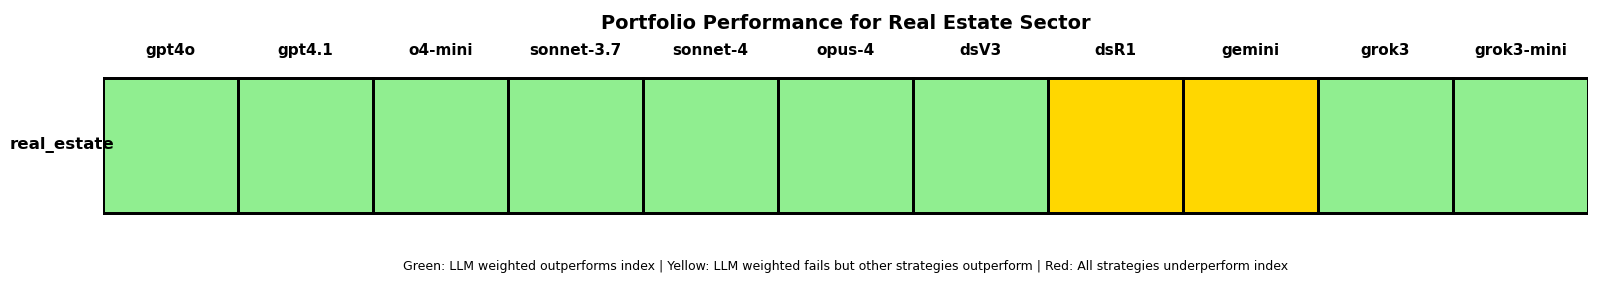

In [807]:
import matplotlib.patches as patches

data = cumulative_returns_diff_comp.mean()


models = []
for idx in data.index:
    model = idx.split('_')[0] 
    if ' ' in model:  
        model = idx.split(' ')[0]
    if model not in models:
        models.append(model)

colors = []

for model in models:
    weighted_value = None
    other_values = []
    
    for idx, value in data.items():
        if idx.startswith(model):
            if 'weighted' in idx:
                weighted_value = value
            else:
                other_values.append(value)
    
    if weighted_value is not None and weighted_value < 0:
        colors.append('#90EE90')
    elif weighted_value is not None and any(v < 0 for v in other_values):
        colors.append('#FFD700') 
    else:
        colors.append('#FFB6C1')

fig, ax = plt.subplots(figsize=(len(models)*1.5, 3))
ax.set_xlim(0, len(models))
ax.set_ylim(0, 2)
ax.set_aspect('equal')

for j, (model, color) in enumerate(zip(models, colors)):
    
    rect = patches.Rectangle((j, 0.5), 1, 1, 
                           linewidth=2, edgecolor='black', facecolor=color)
    ax.add_patch(rect)

for j, model in enumerate(models):
    ax.text(j+0.5, 1.7, model, ha='center', va='center', 
            fontweight='bold', fontsize=11)

ax.text(-0.3, 1, sector_name, ha='center', va='center', 
        fontweight='bold', fontsize=12)

ax.axhline(y=0.5, xmin=0, xmax=1, color='black', linewidth=2)
ax.axhline(y=1.5, xmin=0, xmax=1, color='black', linewidth=2)
for j in range(len(models) + 1):
    ax.axvline(x=j, ymin=0.5/2, ymax=1.5/2, color='black', linewidth=2)

ax.text(len(models)/2, 1.9, f'Portfolio Performance for {sector_name_full} Sector', 
        ha='center', va='center', fontweight='bold', fontsize=14)

legend_text = ('Green: LLM weighted outperforms index | '
               'Yellow: LLM weighted fails but other strategies outperform | '
               'Red: All strategies underperform index')
ax.text(len(models)/2, 0.1, legend_text, ha='center', va='center', fontsize=9)

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

plt.tight_layout()
plt.show()

## Summary metrics preparation

In [808]:
sector_diff_summary = cumulative_returns_diff_comp.mean()

sector_results = pd.DataFrame({
    'sector': sector_name,
    'portfolio': sector_diff_summary.index,
    'difference': sector_diff_summary.values
})

csv_filename = 'difference/sector_performance_differences_stocks20_Oct.csv'

if os.path.exists(csv_filename):
    existing_data = pd.read_csv(csv_filename)
    if sector_name in existing_data['sector'].values:
        print(f"Updated data for sector: {sector_name}")
    else:
        print(f"Added new sector: {sector_name}")
    existing_data = existing_data[existing_data['sector'] != sector_name]
    combined_data = pd.concat([existing_data, sector_results], ignore_index=True)
    combined_data.to_csv(csv_filename, mode='w', header=True, index=False)
else:
    sector_results.to_csv(csv_filename, mode='w', header=True, index=False)
    print(f"Created new file with sector: {sector_name}")

print(f"Data has been saved to {csv_filename}")
print(f"Current sector: {sector_name}")
print(f"Saved {len(sector_results)} indicators")

Updated data for sector: real_estate
Data has been saved to difference/sector_performance_differences_stocks20_Oct.csv
Current sector: real_estate
Saved 55 indicators


## Volatilities

In [809]:
# for model_short in model_shorts:

#     sector_mean = cumulative_returns_compare[f'{model_short}_weighted_{sector_name}'].mean()
#     sector_diff_sq = cumulative_returns_compare[f'{model_short}_weighted_{sector_name}'].apply(lambda x: (x - sector_mean)**2)
#     sector_sumdiff = sector_diff_sq.sum() / cumulative_returns_compare.size
#     sector_volatility = round(sqrt(sector_sumdiff), 5)

#     print(sector_name, sector_volatility, model_short)
#     with open('metrics/portfolio_volatilities.csv', 'a', encoding='utf-8') as f:
#         f.write(f'{model_short},{sector_name},'Oct',{sector_volatility}\n')

In [810]:
if not os.path.exists('metrics/portfolio_volatilities.csv'):
    pd.DataFrame(columns=['model', 'sector', 'time split', 'volatility']).to_csv('metrics/portfolio_volatilities.csv', index=False)

df = pd.read_csv('metrics/portfolio_volatilities.csv')

for model_short in model_shorts:
    sector_data = cumulative_returns_compare[f'{model_short}_weighted_{sector_name}']
    sector_volatility = round(sector_data.std(), 5)

    print(sector_name, sector_volatility, model_short)

    condition = (df['model'] == model_short) & (df['sector'] == sector_name) & (df['time split'] == 'Oct')
    
    if condition.any():
        df.loc[condition, 'volatility'] = sector_volatility
    else:
        new_row = pd.DataFrame({
            'model': [model_short],
            'sector': [sector_name], 
            'time split': ['Oct'],
            'volatility': [sector_volatility]
        })
        df = pd.concat([df, new_row], ignore_index=True)

df.to_csv('metrics/portfolio_volatilities.csv', index=False)

real_estate 0.02507 gpt4o
real_estate 0.02543 gpt4.1
real_estate 0.02625 o4-mini
real_estate 0.02624 sonnet-3.7
real_estate 0.02612 sonnet-4
real_estate 0.0248 opus-4
real_estate 0.02672 dsV3
real_estate 0.02645 dsR1
real_estate 0.02712 gemini
real_estate 0.0235 grok3
real_estate 0.0246 grok3-mini


## Sector Index Volatility (not finished)

In [811]:
# globals()[f'insample_stock_returns_{sector_name}'] = df_returns[globals()[f'stocks_{sector_name}']]
# temp_stock_return_insample = globals()[f'insample_stock_returns_{sector_name}']
# cumulative_returns_gpt_insample = pd.DataFrame(index=temp_stock_return_insample.index)
# cumulative_returns_gpt_insample

# i = 0
# for name, weight in weights.items():
#     temp_stock_return = globals()[f'insample_stock_returns_{sector_name}']
#     portfolio_return = (temp_stock_return * weight).sum(axis=1)
#     cumulative_returns_gpt_insample[name] = (1 + portfolio_return).cumprod()
#     i+=1

# print(cumulative_returns_gpt_insample.columns)

# cumulative_returns_gpt_insample[index_names[sector_ticker]] = (1 + index_data_ins[ticker]).cumprod()

# cumulative_returns_gpt_insample.index = pd.to_datetime(cumulative_returns_gpt_insample.index)
# insample_data = cumulative_returns_gpt_insample.loc[insample_startdate:insample_enddate]


# insample_data

## Portfolio Performance

Plot with Scrollable Legend (Display Only)

In [812]:
temp_index_data_outs_compare = index_data_outs.copy()

temp_index_data_outs_compare.index = pd.to_datetime(temp_index_data_outs_compare.index)

index_first_date_compare = temp_index_data_outs_compare.index[0]
index_previous_trading_date_compare = index_first_date_compare - BDay(1)

index_baseline_row_compare = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs_compare.shape[1])),  
    index=[index_previous_trading_date_compare],                 
    columns=temp_index_data_outs_compare.columns               
)

temp_index_data_outs_compare_with_baseline = pd.concat([index_baseline_row_compare, temp_index_data_outs_compare])
# ##above is to add a baseline row with zeros to the index data outs compare dataframe##

index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

cumulative_returns_compare[index_names[sector_ticker]] = (1 + index_data_outs[ticker]).cumprod()

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)
outsample_data = cumulative_returns_compare.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for i, column in enumerate(outsample_data.columns):
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))

    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Oct 1 to Dec 31, 2024', 
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified",
    height=600
)

fig.update_layout(legend=dict(orientation = "v", yanchor="top",y=1,xanchor="left", x=1.02))


fig.show()


Plot with Multi-Column Legend (For Download/Export)

In [813]:
temp_index_data_outs_compare = index_data_outs.copy()

temp_index_data_outs_compare.index = pd.to_datetime(temp_index_data_outs_compare.index)

index_first_date_compare = temp_index_data_outs_compare.index[0]
index_previous_trading_date_compare = index_first_date_compare - BDay(1)

index_baseline_row_compare = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs_compare.shape[1])),  
    index=[index_previous_trading_date_compare],                 
    columns=temp_index_data_outs_compare.columns               
)

temp_index_data_outs_compare_with_baseline = pd.concat([index_baseline_row_compare, temp_index_data_outs_compare])
# ##above is to add a baseline row with zeros to the index data outs compare dataframe##

index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

cumulative_returns_compare[index_names[sector_ticker]] = (1 + temp_index_data_outs_compare_with_baseline[ticker]).cumprod() ##

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)
outsample_data = cumulative_returns_compare.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for i, column in enumerate(outsample_data.columns):
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))

    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Oct 1 to Dec 31, 2024', 
    title_x = 0.5,
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified",
    width=1400,        
    height=800,
    margin=dict(b=150) 
)

# fig.update_layout(legend=dict(orientation = "v", yanchor="top",y=1,xanchor="left", x=1.02))
fig.update_layout(legend=dict(
        orientation="h", 
        yanchor="top",
        y=-0.15,  
        xanchor="center",
        x=0.5,
        font=dict(size=10)
    ))

fig.show()


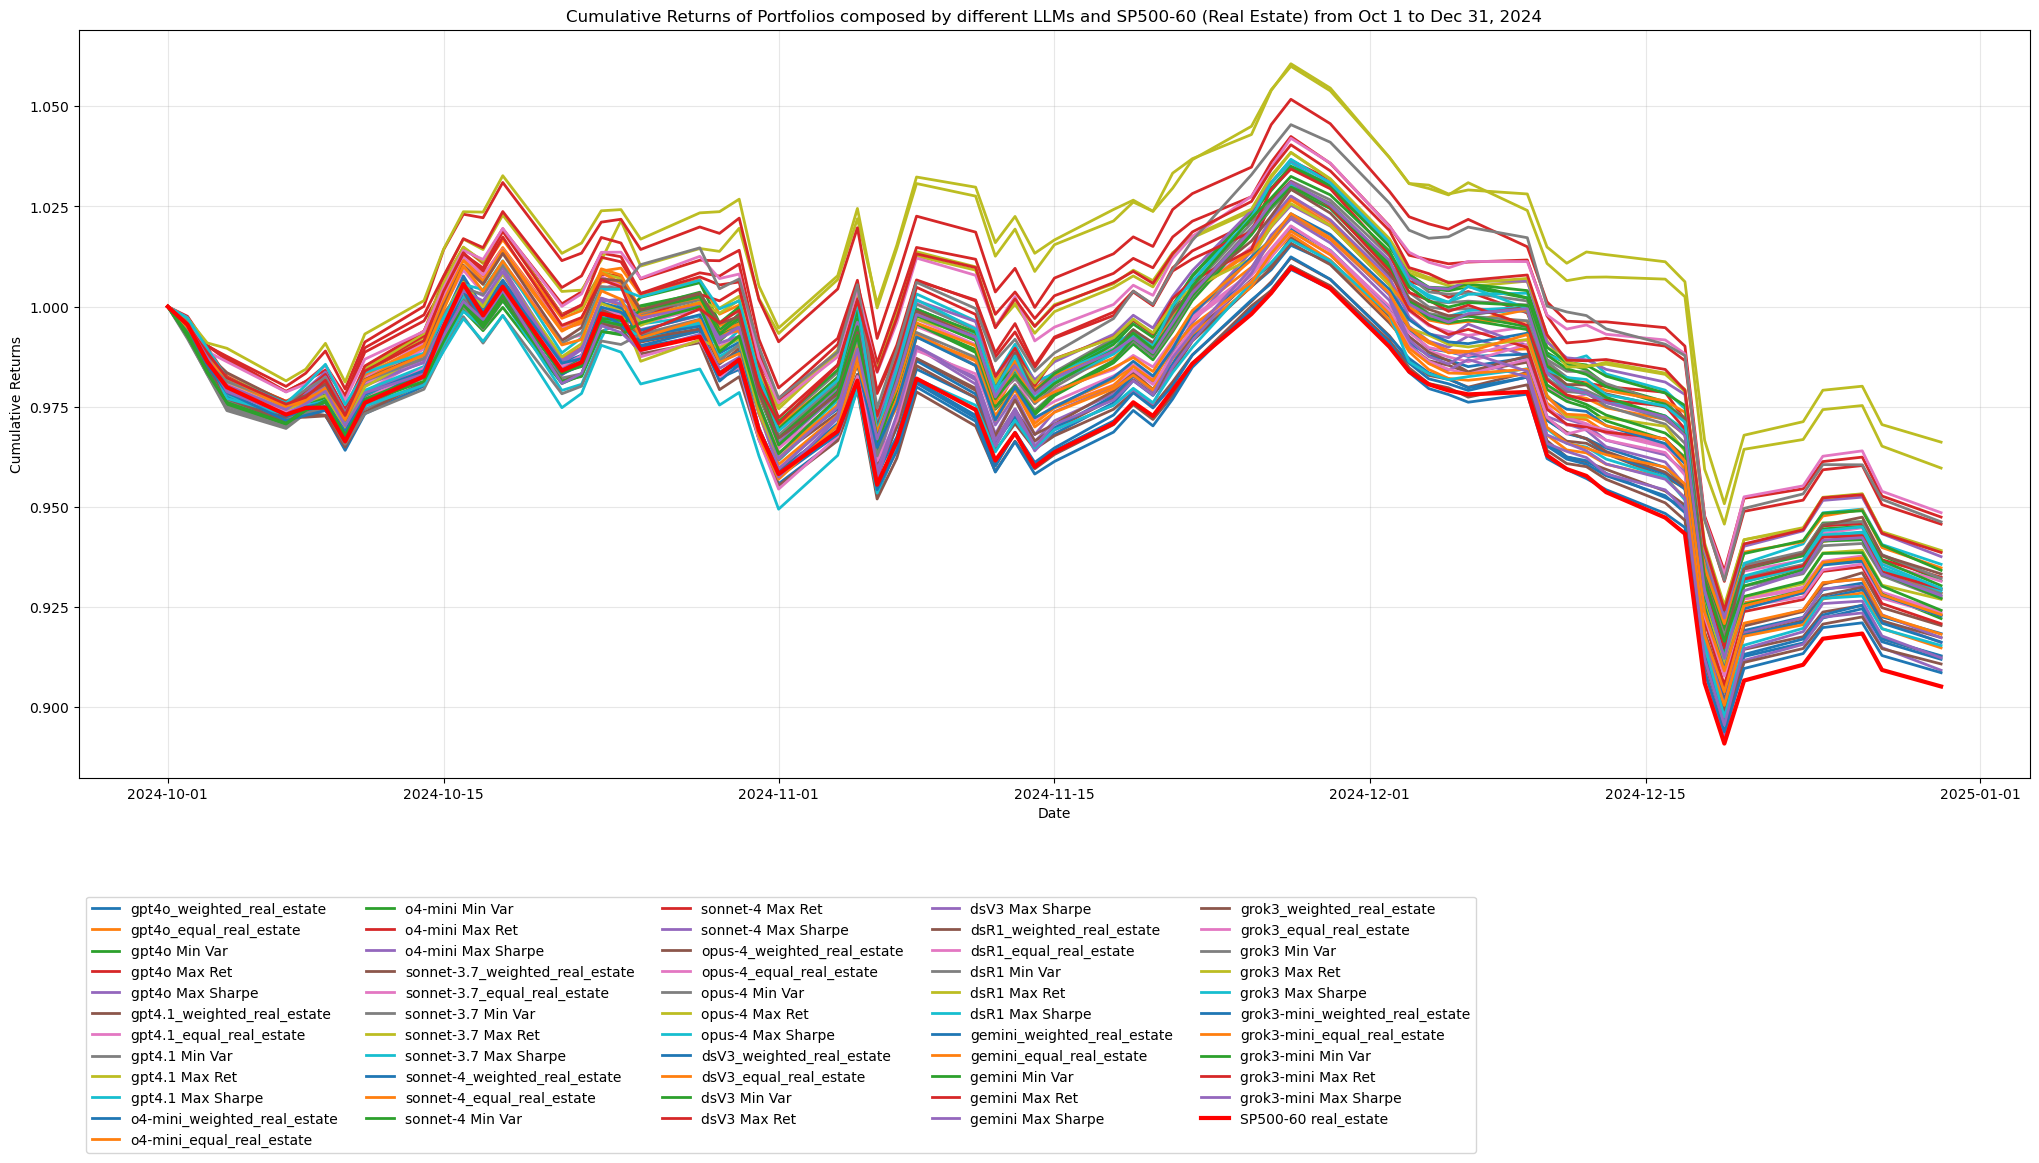

In [814]:
fig, ax = plt.subplots(figsize=(20.5,12))

for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        ax.plot(outsample_data.index, outsample_data[column], 
               linewidth=3, color='red', label=column)
    else:
        ax.plot(outsample_data.index, outsample_data[column], 
               linewidth=2, label=column)

ax.set_title(f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Oct 1 to Dec 31, 2024')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
ax.legend(bbox_to_anchor=(0, -0.15), loc='upper left', ncol=5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()